In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import zstandard as zstd
from scipy.stats import gaussian_kde
import random

In [3]:
interactions_file = "mirmap_202203_homsap_targets_1to1_pt.csv.zst"

In [5]:
with open(interactions_file, 'rb') as f:
    dctx = zstd.ZstdDecompressor()
    with dctx.stream_reader(f) as reader:
        df_sample = pd.read_csv(reader, nrows=100)  # Load only first 100 rows

In [7]:
min_score = df_sample['mirmap_score'].min()
max_score = df_sample['mirmap_score'].max()

print(f"Minimum score: {min_score}")
print(f"Maximum score: {max_score}")

Minimum score: 3.799194
Maximum score: 98.680744


In [9]:
print("Available columns in miRmap dataset:", df_sample.columns)
print("First few rows of the dataset:\n", df_sample.head())

Available columns in miRmap dataset: Index(['mirna_id', 'transcript_stable_id', 'site_nb', 'seed6_nb', 'seed7_nb',
       'tgs_au', 'tgs_position', 'tgs_pairing3p', 'dg_duplex', 'dg_binding',
       'dg_duplex_seed', 'dg_binding_seed', 'dg_open', 'dg_total',
       'prob_exact', 'prob_binomial', 'cons_bls', 'selec_phylop',
       'mirmap_score'],
      dtype='object')
First few rows of the dataset:
        mirna_id transcript_stable_id  site_nb  seed6_nb  seed7_nb     tgs_au  \
0  MIMAT0000062      ENST00000001008        2         1         1  68.685948   
1  MIMAT0000062      ENST00000002829        1         0         1  70.089705   
2  MIMAT0000062      ENST00000003084        1         1         0  67.436419   
3  MIMAT0000062      ENST00000005259        1         1         0   1.213041   
4  MIMAT0000062      ENST00000007699        2         1         1  85.644264   

   tgs_position  tgs_pairing3p  dg_duplex  dg_binding  dg_duplex_seed  \
0     34.419930      38.302663  51.454455  

In [11]:
sns.set(style="whitegrid")

global_min = np.inf
global_max = -np.inf

CHUNK_SIZE = 500_000

mirna_kde_data = {}

In [13]:
# Function to read .zst file in smaller chunks - due to large file
def read_large_zst(file_path, chunksize=CHUNK_SIZE):
    with open(file_path, 'rb') as f:
        dctx = zstd.ZstdDecompressor()
        with dctx.stream_reader(f) as reader:
            chunk_iter = pd.read_csv(reader, chunksize=chunksize, usecols=['mirna_id', 'transcript_stable_id', 'mirmap_score'])
            for chunk in chunk_iter:
                yield chunk

for chunk in read_large_zst(interactions_file):
    chunk_scores = chunk['mirmap_score'].dropna()
    global_min = min(global_min, chunk_scores.min())
    global_max = max(global_max, chunk_scores.max())

x_common = np.linspace(global_min, global_max, 200)

In [51]:
print(global_max)

100.0


In [ ]:
# Identify how many unique mirna ids are there

In [33]:
unique_mirnas = set()

# Read in chunks to avoid memory overload
with open(interactions_file, 'rb') as f:
    dctx = zstd.ZstdDecompressor()
    with dctx.stream_reader(f) as reader:
        for chunk in pd.read_csv(reader, chunksize=500_000, usecols=['mirna_id']):
            unique_mirnas.update(chunk['mirna_id'].dropna().unique())

print(f"Total unique miRNA IDs: {len(unique_mirnas)}")

Total unique miRNA IDs: 2656


In [15]:
# compute KDE per miRNA
for chunk in read_large_zst(interactions_file):
    for mirna, group in chunk.groupby('mirna_id'):
        scores = group['mirmap_score'].dropna()
        if len(scores) > 100 and scores.nunique() > 1:
            kde = gaussian_kde(scores)
            mirna_kde_data.setdefault(mirna, []).append(kde(x_common))

# Average over chunks and convert to DataFrame
kde_df = pd.DataFrame({mirna: np.mean(kdes, axis=0) for mirna, kdes in mirna_kde_data.items()}, index=x_common)

In [16]:
mean_kde = kde_df.mean(axis=1)
std_kde = kde_df.std(axis=1)

Save as PNG? (yes/no):  yes


Saved as 'miRmap_KDE_STD.png'.


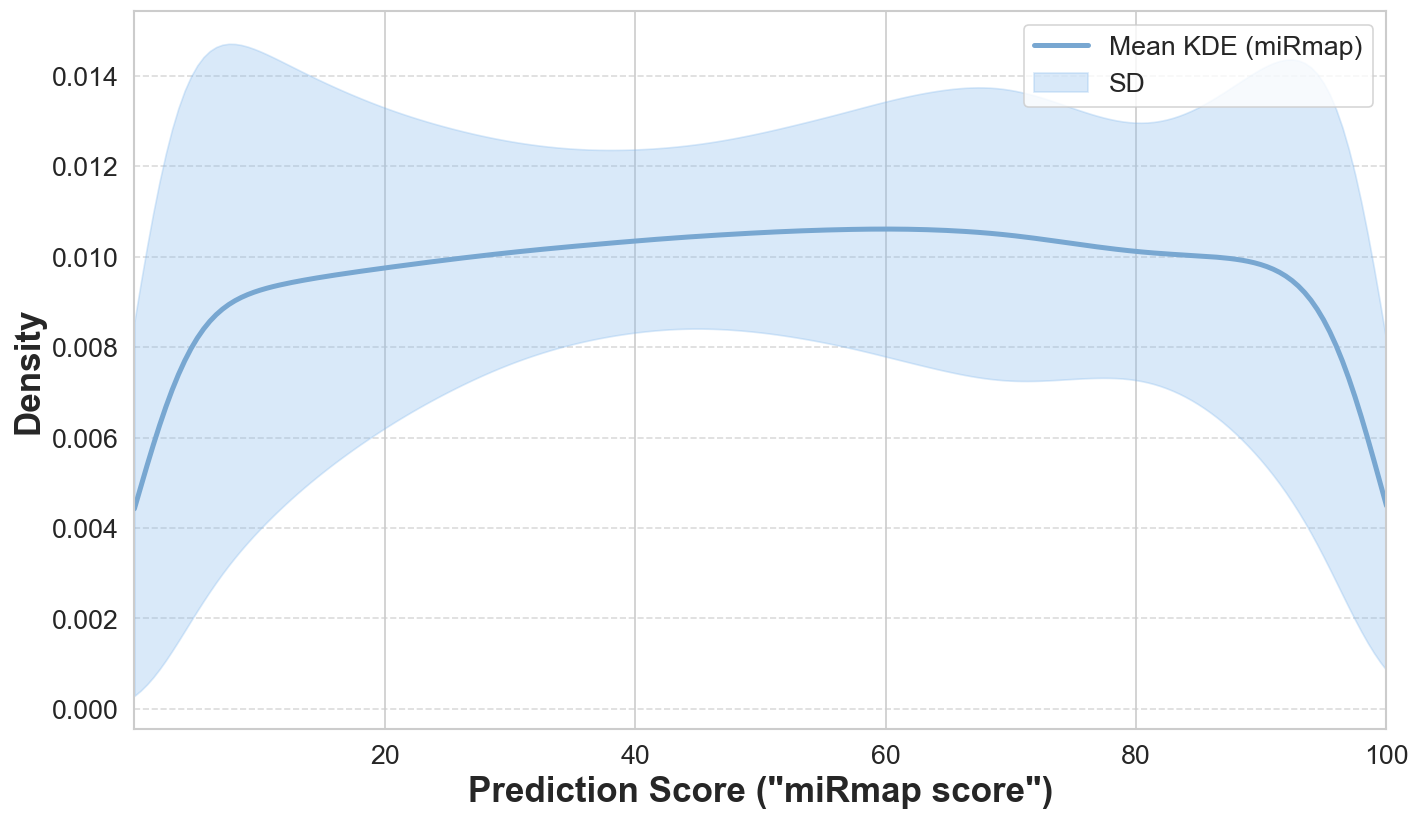

In [31]:
plt.figure(figsize=(12, 7), dpi=120)

plt.plot(x_common, mean_kde, color='#78A7D1', linewidth=3, label="Mean KDE (miRmap)")
plt.fill_between(x_common, mean_kde - std_kde, mean_kde + std_kde, color='#82B8ED', alpha=0.3, label="SD")

plt.xlabel('Prediction Score ("miRmap score")', fontsize=21, fontweight="bold")
plt.ylabel('Density', fontsize=21, fontweight="bold")
plt.xlim(global_min, global_max)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=16, loc='upper right')
plt.tick_params(axis='both', labelsize=16)
plt.tight_layout()


save_plot = input("Save as PNG? (yes/no): ").strip().lower()
if save_plot == 'yes':
    plt.savefig("miRmap_KDE_STD.png", format='png', dpi=300, bbox_inches='tight')
    print("Saved as 'miRmap_KDE_STD.png'.")

plt.show()